# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a public raw GitHub URL
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)

# Step 1: Handling Missing Values
# Water sensors often fail, leaving NaNs. We will fill them with the mean of the column.
df.fillna(df.mean(), inplace=True)

# Step 2: Feature Selection & Labeling
# We'll use all chemical features to predict 'Potability'
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Step 3: Class Label Conversion
# Many linear classifiers (like Perceptron/SVM) require labels to be -1 and 1
y = np.where(y == 0, -1, 1)

# Step 4: Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)

The **Perceptron** represents the earliest form of supervised learning. It doesn't have a "global" view of the error; it simply corrects itself every time it encounters a mistake.

**Task:** Implement the Perceptron Update Rule inside the training loop.

In [18]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])

        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):
                linear_output = np.dot(X[i], self.w) + self.b
                y_pred = np.sign(linear_output)

                if y_pred != y[i]:
                    self.w += self.lr * y[i] * X[i]
                    self.b += self.lr * y[i]
                    count += 1

            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_p = WaterPerceptron()
model_p.fit(X_train, y_train)



# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

**Task:** Implement the batch gradient calculation for weights and bias.

In [19]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
            z = np.dot(X, self.w) + self.b
            dw = (1 / n) * X.T.dot(z - y)
            db = (1 / n) * np.sum(z - y)
            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [20]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                if y[i] * (np.dot(x_i, self.w) + self.b) >= 1:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - x_i * y[i])
                    self.b -= self.lr * (-y[i])

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother.
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models.
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why?

1.

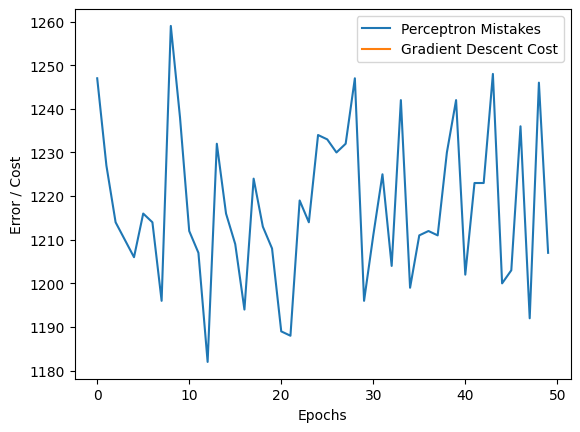

In [21]:
model_gd = GDWaterClassifier()
model_gd.fit(X_train, y_train)

plt.plot(model_p.mistakes, label="Perceptron Mistakes")
plt.plot(model_gd.cost_history, label="Gradient Descent Cost")
plt.xlabel("Epochs")
plt.ylabel("Error / Cost")
plt.legend()
plt.show()

Gradient Descent showed a smoother curve because it updates weights using the average error over all samples, whereas the Perceptron updates weights only when a misclassification occurs, causing abrupt changes.

2.

In [22]:
model_margin = MarginWaterClassifier()
model_margin.fit(X_train, y_train)

acc_p = np.mean(model_p.predict(X_test) == y_test)
acc_gd = np.mean(model_gd.predict(X_test) == y_test)
acc_margin = np.mean(model_margin.predict(X_test) == y_test)

print("Perceptron Accuracy:", acc_p)
print("Gradient Descent Accuracy:", acc_gd)
print("Margin Classifier Accuracy:", acc_margin)

Perceptron Accuracy: 0.5015243902439024
Gradient Descent Accuracy: 0.6280487804878049
Margin Classifier Accuracy: 0.6280487804878049


3.The Margin-based classifier is more reliable because it maximizes the distance between classes. Samples close to the decision boundary are classified more robustly compared to the Perceptron, which is sensitive to small variations.

# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?
*Hint: Think about convergence, overshooting, and divergence.*

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?
*Hint: Consider the mathematical formulation of the loss function (e.g., Hinge Loss) and symmetry.*

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?
*Hint: Think about robustness to outliers and margin-based classifiers.*


# ANSWERS

1)If the learning rate is set too high (for example, 1.0), the Gradient Descent model may overshoot the optimal minimum instead of converging to it. This can cause the loss to oscillate or even diverge, leading to unstable training and poor model performance.

2)Labels {-1, 1} are needed for symmetric, sign-based and margin-based loss calculations.

3)The Margin-based classifier (SVM-style) is best suited for noisy data. By maximizing the margin, it becomes more robust to outliers and small fluctuations in feature values. The Perceptron is sensitive to noise and may fail to converge when data is not linearly separable.